In [18]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

In [169]:
def generate_roc_with_auc(target_auc, num_points=1000):
    # Generate a ROC curve with the given AUC
    fpr = np.linspace(0, 1, num_points)
    tpr = fpr ** (target_auc / (1 - target_auc + 1e-6))  # Adjust shape to match target AUC
    
    # Smooth the curve using interpolation
    interp = scipy.interpolate.interp1d(fpr, tpr, kind='linear', fill_value='extrapolate')
    fpr_smooth = np.linspace(0, 1, num_points)
    tpr_smooth = interp(fpr_smooth)
    
    return fpr_smooth, tpr_smooth

def compute_eer(fpr, tpr):
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.nanargmin(np.abs(fpr - fnr))  # Find the closest point where FPR ≈ FNR
    eer = fpr[eer_index]  # EER is where FPR and FNR are equal
    return eer


C:\Users\odink\AppData\Local\Temp\ipykernel_20568\840904985.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [0, 1], 'k--', label='EER line', color="blue")


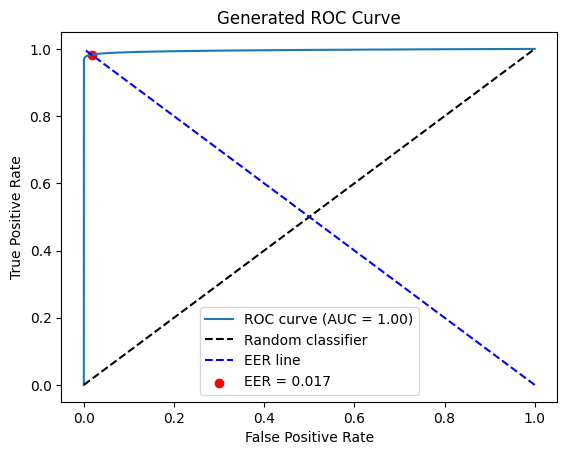

Estimated EER for AUC 0.9958: 0.017


: 

In [264]:
def main(target_auc):
    fpr, tpr = generate_roc_with_auc(target_auc)
    eer = compute_eer(tpr, fpr)
    
    # Plot ROC curve
    plt.plot(tpr, fpr, label=f'ROC curve (AUC = {target_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.plot([1, 0], [0, 1], 'k--', label='EER line', color="blue")
    plt.scatter([eer], [1 - eer], color='red', label=f'EER = {eer:.3f}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Generated ROC Curve')
    plt.legend()
    plt.show()
    
    return eer

target_auc = .9958
eer_value = main(target_auc)
print(f'Estimated EER for AUC {target_auc}: {eer_value:.3f}')


In [262]:
import numpy as np
from scipy.optimize import minimize
import scipy.interpolate
from scipy.integrate import trapezoid  # Replacing deprecated trapz

# Function to generate ROC curve with parametric AUC
def generate_parametric_roc_curve(params, num_points=1000):
    # Example: Use a simple sigmoid function to control the curve shape
    fpr = np.linspace(0, 1, num_points)
    tpr = 1 / (1 + np.exp(-params[0] * (fpr - params[1])))  # Logistic curve
    
    # Smooth the curve using interpolation
    interp = scipy.interpolate.interp1d(fpr, tpr, kind='linear', fill_value='extrapolate')
    tpr_smooth = interp(fpr)
    
    return fpr, tpr_smooth

# Function to calculate the AUC
def calculate_auc(fpr, tpr):
    return trapezoid(tpr, fpr)  # Using the recommended trapezoid function

# Function to compute EER
def compute_eer(fpr, tpr):
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.nanargmin(np.abs(fpr - fnr))  # Find the closest point where FPR ≈ FNR
    eer = fpr[eer_index]  # EER is where FPR and FNR are equal
    return eer

# Objective function to maximize EER while maintaining fixed AUC
def objective(params, target_auc, num_points=1000):
    # Generate the ROC curve with current parameters
    fpr, tpr = generate_parametric_roc_curve(params, num_points)
    
    # Calculate the AUC of the curve
    auc = calculate_auc(fpr, tpr)
    
    # Compute the EER
    eer = compute_eer(fpr, tpr)
    
    # Penalize if the AUC deviates from the target AUC
    auc_penalty = np.abs(auc - target_auc)
    
    # We want to maximize EER, so we minimize the negative of EER and add the AUC penalty
    return -eer + auc_penalty * 10  # The constant (10) is a weight for AUC penalty

# Function to find the parameters that maximize the EER while satisfying the AUC constraint
def find_max_eer_curve(target_auc, initial_params=None, num_points=10000):
    if initial_params is None:
        initial_params = [10, 0.5]  # Some initial guess for the sigmoid parameters
    
    # Add bounds to the optimization to avoid unreasonable parameter values
    bounds = [(0.1, 75), (0, 1)]  # Reasonable bounds for parameters
    
    # Use optimization to find the parameters that maximize the EER while keeping AUC fixed
    result = minimize(objective, initial_params, args=(target_auc, num_points), method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        # Extract the optimal parameters
        optimal_params = result.x
        fpr, tpr = generate_parametric_roc_curve(optimal_params, num_points)
        eer = compute_eer(fpr, tpr)
        return fpr, tpr, eer, calculate_auc(fpr, tpr)
    else:
        raise ValueError(f"Optimization did not converge: {result.message}")

# Example usage: Find the ROC curve with maximum EER for a given AUC
target_auc = .99 # Set the desired AUC
fpr, tpr, eer, auc = find_max_eer_curve(target_auc)
print(f"Max EER: {eer}, AUC: {auc}")

Max EER: 0.04430443044304431, AUC: 0.9899999999991582
